In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np
import keras
from keras import layers


In [2]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

--2021-02-08 19:08:08--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 74.125.31.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-02-08 19:08:08 (60.2 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [3]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [4]:

model = keras.models.Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(layers.Bidirectional(layers.LSTM(256)))
# model.add(layers.LSTM(128))
model.add(layers.Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics='accuracy')


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               731136    
_________________________________________________________________
dense (Dense)                (None, 3211)              1647243   
Total params: 2,699,479
Trainable params: 2,699,479
Non-trainable params: 0
_________________________________________________________________


In [6]:
# where does the 484 in each epoch come from?
history = model.fit(predictors, label, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 5s 9ms/step - loss: 6.8722 - accuracy: 0.0217
Epoch 2/50
484/484 [==============================] - 4s 9ms/step - loss: 6.4260 - accuracy: 0.0326
Epoch 3/50
484/484 [==============================] - 4s 9ms/step - loss: 6.1564 - accuracy: 0.0431
Epoch 4/50
484/484 [==============================] - 4s 9ms/step - loss: 5.8434 - accuracy: 0.0543
Epoch 5/50
484/484 [==============================] - 4s 9ms/step - loss: 5.4546 - accuracy: 0.0698
Epoch 6/50
484/484 [==============================] - 4s 9ms/step - loss: 4.9840 - accuracy: 0.0891
Epoch 7/50
484/484 [==============================] - 4s 9ms/step - loss: 4.4189 - accuracy: 0.1293
Epoch 8/50
484/484 [==============================] - 5s 10ms/step - loss: 3.8065 - accuracy: 0.2091
Epoch 9/50
484/484 [==============================] - 4s 9ms/step - loss: 3.2141 - accuracy: 0.3166
Epoch 10/50
484/484 [==============================] - 4s 9ms/step - loss: 2.7044 - accuracy: 0.411

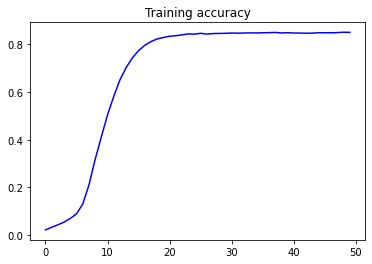

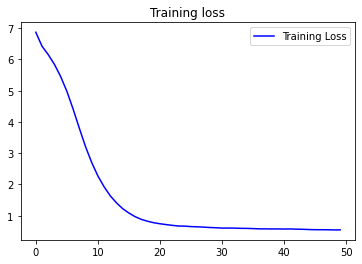

In [7]:

import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()


In [8]:

#outcome of the seed text without - with learning rate chosen for Adam optimizer 
seed_text = "love thy foe as thy sweet not cruel"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

love thy foe as thy sweet not cruel did shine alone had thee thy praise one date of praise date me place me seen weep best torn brow her heart find bright ' latch ' ' see hate of pleasure her fears with thee more rare rare rare offenders mind of this hate forth truth even tripping be divide thee done thee lies bright alone had ' near slain her 'will ' ' ' now thee bright bright heart contains latch treasure thee again of even trees there rare brow skill more rare rare rare more her ' be bevel cold bent to wrong long long hate aside


Although the generated text contains words more appropriate to the context like: offenders mind of this hate, a lot of words are repeated. Also the words are mixed with female gender and that's neither cohesive nor interesting.

It becomes clear that with more nodes comes more parameters and when the network grows we have to introduce dropout, normalization, and other techniques to improve its performance.